# Parte 2 — Modelado y Pronóstico
**C7 IA Innovador**  
**Ing.** Engler González · **Objetivo:** comparar baselines vs. SARIMA y pronosticar h=12


## 0) Carga y split temporal
Cargamos el CSV de la Parte 1. Si no existe, recreamos la serie como respaldo.  
Luego separamos **train** y **test** (últimos 12 puntos por defecto).


In [1]:
from pathlib import Path
import pandas as pd

csv_path = Path('serie_preprocesada_parte2.csv')
if csv_path.exists():
    df_csv = pd.read_csv(csv_path)
    display(df_csv.head())
else:
    print(f"El archivo {csv_path} no se encontró.")

El archivo serie_preprocesada_parte2.csv no se encontró.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = Path('serie_preprocesada_parte2.csv')
if csv_path.exists():
    df = pd.read_csv(csv_path, parse_dates=['ds'], index_col='ds')
else:
    # Respaldo sintético
    idx = pd.date_range('2016-01-01', periods=120, freq='MS')
    rng = np.random.default_rng(7)
    trend = np.linspace(100, 220, len(idx))
    season = 12 * np.sin(2*np.pi*(idx.month/12.0))
    noise = rng.normal(0, 2.2, len(idx))
    y = trend + season + noise
    df = pd.DataFrame({'y': y}, index=idx)
    df.index.name = 'ds'

# Asegurar frecuencia
freq = pd.infer_freq(df.index) or 'MS'
df = df.asfreq(freq)

# Split temporal: h=12 si la serie lo permite
h = 12 if len(df) >= 36 else max(3, len(df)//6)
train, test = df.iloc[:-h].copy(), df.iloc[-h:].copy()
print(f'Train={len(train)} | Test={len(test)} | h={h} | freq={freq}')


Train=108 | Test=12 | h=12 | freq=MS


## 1) Baselines (Naive y Seasonal Naive)
**Naive** repite el último valor del train.  
**Seasonal Naive** repite el patrón de hace m pasos (m≈12 para mensual).


In [3]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-9, np.abs(y_true)))) * 100.0

def mase(y_true, y_pred, y_train):
    # MAE del modelo / MAE del naive-1 en train
    mae_model = np.mean(np.abs(y_true - y_pred))
    naive1 = np.abs(np.diff(y_train)).mean()
    return mae_model / np.maximum(1e-9, naive1)

m = 12 if str(freq).upper().endswith('S') else 1

# Naive
y_last = float(train['y'].iloc[-1])
yhat_naive = np.repeat(y_last, len(test))

# Seasonal Naive
if m > 1 and len(train) > m:
    pattern = train['y'].iloc[-m:].to_numpy()
    reps = int(np.ceil(len(test)/len(pattern)))
    yhat_snaive = np.tile(pattern, reps)[:len(test)]
else:
    yhat_snaive = yhat_naive.copy()

import pandas as pd
metrics_base = pd.DataFrame({
    'modelo': ['naive','snaive'],
    'MAE': [np.mean(np.abs(test['y'].to_numpy()-yhat_naive)),
            np.mean(np.abs(test['y'].to_numpy()-yhat_snaive))],
    'RMSE': [np.sqrt(np.mean((test['y'].to_numpy()-yhat_naive)**2)),
             np.sqrt(np.mean((test['y'].to_numpy()-yhat_snaive)**2))],
    'sMAPE': [np.mean(200.0*np.abs(test['y'].to_numpy()-yhat_naive)/(np.abs(test['y'].to_numpy())+np.abs(yhat_naive))),
              np.mean(200.0*np.abs(test['y'].to_numpy()-yhat_snaive)/(np.abs(test['y'].to_numpy())+np.abs(yhat_snaive)))],
})
metrics_base


,modelo,MAE,RMSE,sMAPE
0,naive,7.411571,8.681985,3.473143
1,snaive,12.741639,13.159055,6.114841


## 2) SARIMA (rejilla ligera por AIC) — línea por línea
Probamos combinaciones pequeñas de (p,d,q) y (P,D,Q) con periodo m para encontrar un modelo que minimice **AIC**.


In [4]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_tr = train['y'].copy()
y_te = test['y'].copy()

# Si todo es positivo, probamos log para estabilizar varianza
use_log = (y_tr.min()>0) and (y_te.min()>0)
if use_log:
    y_tr = np.log(y_tr)

p = d = q = [0,1,2]
P = Q = [0,1]
D = [0,1]
M = [m] if m>1 else [1]

best = None; best_aic = np.inf
for (pi,Di,qi,Pi,Qi,Mi) in itertools.product(p, D, q, P, Q, M):
    try:
        model = SARIMAX(y_tr, order=(pi,1,qi), seasonal_order=(Pi,Di,Qi,Mi),
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=2000) # Increased maxiter again
        if res.aic < best_aic:
            best_aic = res.aic
            best = (pi,1,qi,Pi,Di,Qi,Mi,res)
    except Exception:
        continue

if best is None:
    raise RuntimeError("No se encontró SARIMA válido con esta rejilla. Reduce el espacio o verifica la serie.")

pi,di,qi,Pi,Di,Qi,Mi,res = best
print(f"Mejor AIC: order=({pi},{di},{qi}), seasonal=({Pi},{Di},{Qi},{Mi}), AIC={res.aic:.2f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Mejor AIC: order=(0,1,1), seasonal=(1,0,1,12), AIC=-516.70


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 3) Pronóstico y métricas (incluyendo **MASE**)
Convertimos de log si aplicó, y calculamos MAE, RMSE, sMAPE y **MASE** contra naive-1.


In [5]:
pred = res.get_forecast(steps=len(test))
yhat = pred.predicted_mean
if use_log:
    yhat = np.exp(yhat)

y_true = test['y'].to_numpy()
y_pred = yhat.to_numpy()

MAE = np.mean(np.abs(y_true - y_pred))
RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
sMAPE = np.mean(200.0*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)))
MASE = mase(y_true, y_pred, train['y'].to_numpy())

print(f"MAE={MAE:.3f} | RMSE={RMSE:.3f} | sMAPE={sMAPE:.2f}% | MASE={MASE:.3f}")


MAE=2.063 | RMSE=2.422 | sMAPE=0.96% | MASE=0.468


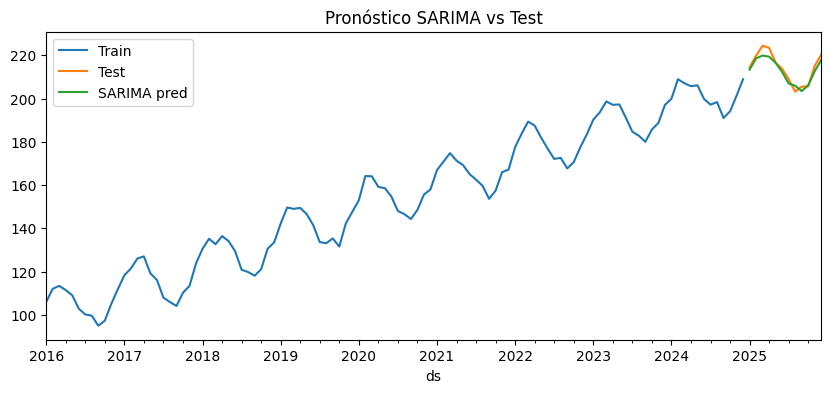

In [6]:
# Gráfico comparativo
fig, ax = plt.subplots(figsize=(10,4))
train['y'].plot(ax=ax, label='Train')
test['y'].plot(ax=ax, label='Test')
yhat.index = test.index
yhat.plot(ax=ax, label='SARIMA pred')
ax.set_title('Pronóstico SARIMA vs Test')
ax.legend(); plt.show()


In [7]:
# Exportar pronósticos
out_csv = 'pronosticos_sarima.csv'
pd.DataFrame({'ds': test.index, 'y_true': y_true, 'y_pred': y_pred}).to_csv(out_csv, index=False)
print('Guardado:', out_csv)


Guardado: pronosticos_sarima.csv
